In [16]:
from pprint import pprint
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from pathlib import Path
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel, LinearFactorModelGMM

In [17]:
plt.style.use('fivethirtyeight')

## Get Data

### Risk Factors

In [33]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    96 non-null float64
SMB       96 non-null float64
HML       96 non-null float64
RMW       96 non-null float64
CMA       96 non-null float64
RF        96 non-null float64
dtypes: float64(6)
memory usage: 5.2 KB


In [34]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158437,0.055625,-0.065833,0.141667,0.045625,0.012604
std,3.579997,2.300743,2.197651,1.552194,1.411270,0.022583
min,-7.890000,-4.570000,-4.500000,-4.030000,-3.340000,0.000000
25%,-0.917500,-1.585000,-1.510000,-1.042500,-0.992500,0.000000
50%,1.235000,0.175000,-0.285000,0.105000,-0.030000,0.000000
75%,3.190000,1.512500,1.125000,1.145000,0.932500,0.010000
max,11.350000,6.930000,8.270000,3.510000,3.670000,0.090000


### Portfolios

Download and convert to excess returns

In [38]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
Food     96 non-null float64
Mines    96 non-null float64
Oil      96 non-null float64
Clths    96 non-null float64
Durbl    96 non-null float64
Chems    96 non-null float64
Cnsum    96 non-null float64
Cnstr    96 non-null float64
Steel    96 non-null float64
FabPr    96 non-null float64
Machn    96 non-null float64
Cars     96 non-null float64
Trans    96 non-null float64
Utils    96 non-null float64
Rtail    96 non-null float64
Finan    96 non-null float64
Other    96 non-null float64
dtypes: float64(17)
memory usage: 13.5 KB


In [39]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.045625,0.203229,0.550833,1.396979,1.154896,1.303438,1.136875,1.731250,0.555625,1.351042,1.227604,1.278854,1.465521,0.891250,1.234375,1.243646,1.282187
std,2.795857,7.902683,5.573364,5.025167,5.137095,5.594231,3.174680,5.246562,7.389824,4.694688,4.811242,5.718887,4.151203,3.237306,3.508655,4.808350,3.711170
min,-5.170000,-24.380000,-11.990000,-10.000000,-13.210000,-17.390000,-7.300000,-13.960000,-20.490000,-11.960000,-9.080000,-11.650000,-8.560000,-6.990000,-9.180000,-11.020000,-7.920000
25%,-0.785000,-5.832500,-3.160000,-1.865000,-2.017500,-1.445000,-0.920000,-2.462500,-4.410000,-1.447500,-2.047500,-1.245000,-0.880000,-0.745000,-0.962500,-1.447500,-1.067500
50%,0.930000,-0.415000,1.050000,1.160000,1.205000,1.435000,1.475000,2.190000,0.660000,1.485000,1.545000,0.645000,1.505000,1.215000,0.880000,1.940000,1.580000
75%,3.187500,5.707500,3.912500,3.857500,4.315000,4.442500,3.317500,5.390000,4.220000,3.875000,4.657500,4.802500,4.227500,2.965000,3.355000,4.052500,3.525000
max,6.670000,21.920000,16.240000,17.200000,16.580000,18.370000,8.290000,15.550000,21.350000,17.660000,14.650000,20.860000,13.160000,7.900000,12.360000,13.430000,10.800000


### Equity Data

In [69]:
with pd.HDFStore('../../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [70]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [71]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1936 entries, A to ZUMZ
dtypes: float64(1936)
memory usage: 1.4 MB


### Align data

In [75]:
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [76]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.052947,-0.069789,0.155263,0.041579,0.012737
std,3.568367,2.312798,2.208966,1.554671,1.418197,0.022665
min,-7.890000,-4.570000,-4.500000,-4.030000,-3.340000,0.000000
25%,-0.565000,-1.600000,-1.530000,-0.920000,-0.995000,0.000000
50%,1.290000,0.140000,-0.290000,0.130000,-0.030000,0.000000
75%,3.260000,1.555000,1.130000,1.150000,0.935000,0.010000
max,11.350000,6.930000,8.270000,3.510000,3.670000,0.090000


#### Compute excess Returns

In [77]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1936 entries, A to ZUMZ
dtypes: float64(1936)
memory usage: 1.4 MB


In [78]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

### Fama-Macbeth Regression

In [79]:
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 17 columns):
Food     95 non-null float64
Mines    95 non-null float64
Oil      95 non-null float64
Clths    95 non-null float64
Durbl    95 non-null float64
Chems    95 non-null float64
Cnsum    95 non-null float64
Cnstr    95 non-null float64
Steel    95 non-null float64
FabPr    95 non-null float64
Machn    95 non-null float64
Cars     95 non-null float64
Trans    95 non-null float64
Utils    95 non-null float64
Rtail    95 non-null float64
Finan    95 non-null float64
Other    95 non-null float64
dtypes: float64(17)
memory usage: 15.9 KB


In [80]:
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    95 non-null float64
SMB       95 non-null float64
HML       95 non-null float64
RMW       95 non-null float64
CMA       95 non-null float64
RF        95 non-null float64
dtypes: float64(6)
memory usage: 5.2 KB


#### Step 1: Factor Exposures

In [81]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [82]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 6 columns):
Mkt-RF    17 non-null float64
SMB       17 non-null float64
HML       17 non-null float64
RMW       17 non-null float64
CMA       17 non-null float64
RF        17 non-null float64
dtypes: float64(6)
memory usage: 1.6+ KB


#### Step 2: Risk Premia

In [83]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [84]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    95 non-null float64
SMB       95 non-null float64
HML       95 non-null float64
RMW       95 non-null float64
CMA       95 non-null float64
RF        95 non-null float64
dtypes: float64(6)
memory usage: 7.7 KB


In [85]:
lambdas.mean()

Mkt-RF    1.244610
SMB       0.007380
HML      -0.696972
RMW      -0.255768
CMA      -0.308635
RF       -0.013344
dtype: float64

In [86]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.347112
SMB       0.001895
HML      -0.200648
RMW      -0.082556
CMA      -0.105439
RF       -0.160318
dtype: float64

#### Results

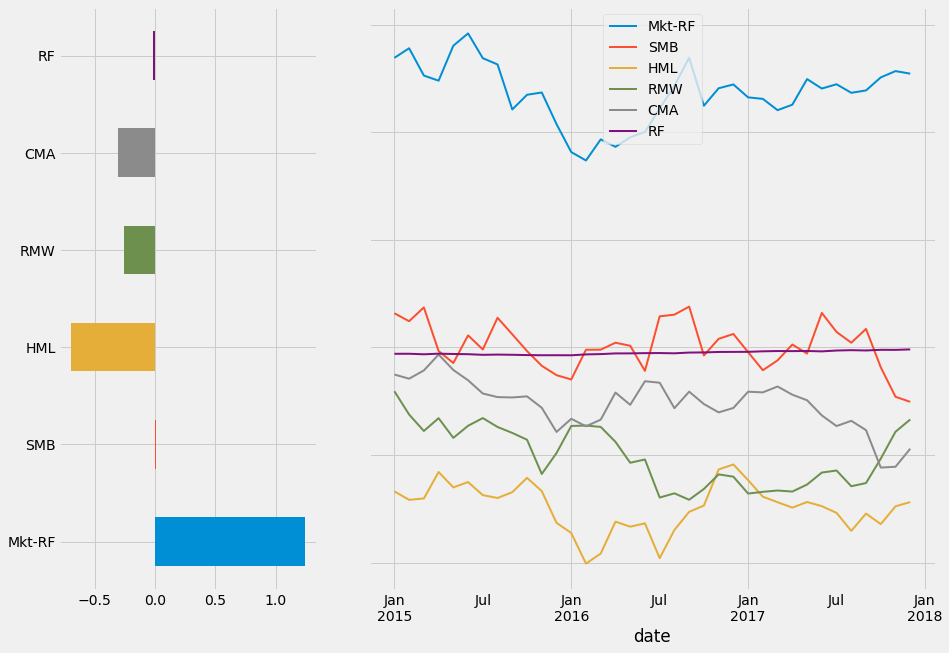

In [87]:
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().plot.barh(ax=ax1)
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), sharey=True, ax=ax2);

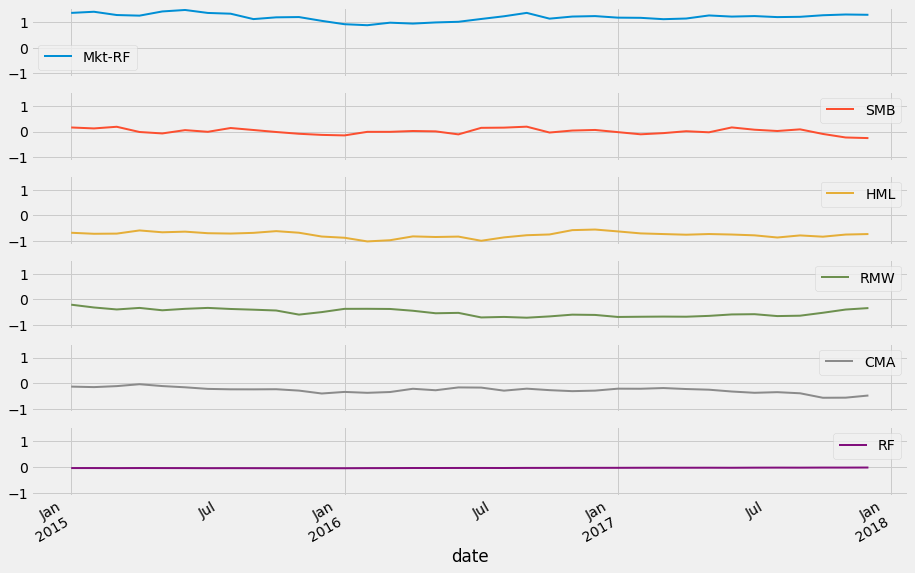

In [88]:
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), subplots=True,sharey=True);

In [92]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6943
No. Factors:                          6   J-statistic:                    19.155
No. Observations:                    95   P-value                         0.0584
Date:                  Wed, Oct 31 2018   Distribution:                 chi2(11)
Time:                          15:15:52                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2446     0.3928     3.1689     0.0015      0.4748      2.0144
SMB            0.0074     0.7055    

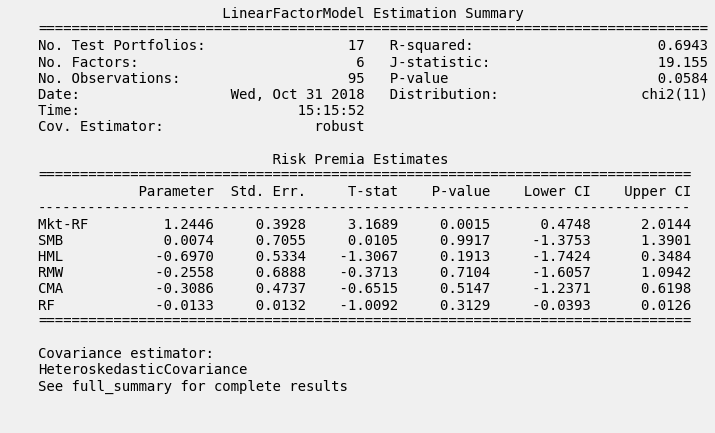

In [93]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('factor_model.png', bbox_inches='tight', dpi=300);

In [91]:
lambdas.mean()

Mkt-RF    1.244610
SMB       0.007380
HML      -0.696972
RMW      -0.255768
CMA      -0.308635
RF       -0.013344
dtype: float64